# Plotting demo

In [1]:
import os
import glob
from pathlib import Path
import torch
import json
from safetensors.torch import load_file
import sys
import re
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import torch.nn.functional as Fn



# Path setup
# For Jupyter Notebook compatibility
try:
    # Get current working directory and find project root
    project_root = Path.cwd()
    # Navigate up until we find the gpt-circuits directory
    while project_root.name != 'gpt-circuits' and project_root != project_root.parent:
        project_root = project_root.parent
    
    if project_root.name != 'gpt-circuits':
        # Fall back to the existing project_root if available
        if 'project_root' not in globals():
            print("Warning: Couldn't locate gpt-circuits directory. Using current directory.")
            project_root = Path.cwd()
    
    print(f"Project root: {project_root}")
    sys.path.append(str(project_root))
except Exception as e:
    print(f"Error setting up paths: {e}")

# Importing custom modules
from xavier.utils import load_experiments_and_extract_data, bootstrap_ci, extract_l1_gradients, extract_compound_ce_loss_increase

str(Path.cwd())

Project root: /Users/xavierponcini/Documents/projects/spar/gpt-circuits


'/Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments'

## Plotting different SAE variants

In [ ]:
# DATA LOADING
exp_output = 'kl_divergence'
data_dir = Path.cwd() / 'data' / 'testing'
method_labels = ['standard', 'topk']
edge_sort = 'gradient'
layers = [0, 1]

# Colors for the plots
colors = ['ro-', 'go-', 'bo-', 'mo-', 'ko-', 'co-']

kl_values_list = []
feature_counts_list = []

for method in method_labels:
    # Load experiments and extract logits
    layer_logits_values, feature_counts = load_experiments_and_extract_data(
        exp_output,
        data_dir, 
        method,
        edge_sort,
        layers
    )
    
    # Store results
    kl_values_list.append(layer_logits_values)
    feature_counts_list.append(feature_counts)

Loaded 88 experiments from /Users/xavierponicni/Documents/spar/gpt-circuits/xavier/experiments/data/testing

Example experiment ID: magnitudes_standard_gradient_1_203892_2025-04-01
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'logits']
Feature magnitudes shape: torch.Size([1, 128, 512])
Logits shape: torch.Size([1, 128, 128])
KL divergence shape: torch.Size([1, 128])
Loaded 88 experiments from /Users/xavierponicni/Documents/spar/gpt-circuits/xavier/experiments/data/testing

Example experiment ID: magnitudes_standard_gradient_1_203892_2025-04-01
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'logits']
Feature magnitudes shape: torch.Size([1, 128, 512])
Logits shape: torch.Size([1, 128, 128])
KL divergence shape: torch.Size([1, 128])


<Figure size 1000x600 with 0 Axes>

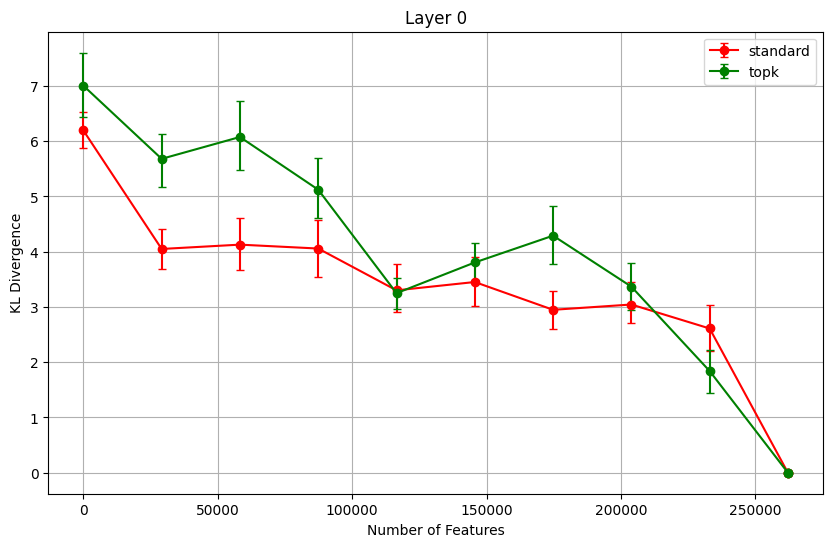

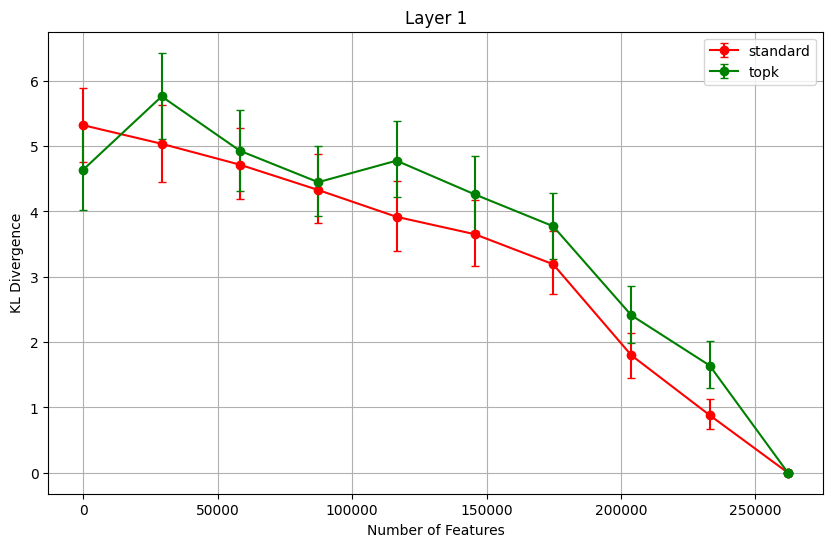

In [ ]:
# PLOTTING

# If token_idx is not None, average over all token positions
token_idx = None 

# Lists to store results
mean_values = []
yerr_lower_values = []
yerr_upper_values = []

# Calculate statistics
for layer_idx in range(len(layers)):
    layer_means = []
    layer_yerr_lower = []
    layer_yerr_upper = []
    
    for method_idx in range(len(method_labels)):
        method_means = []
        method_yerr_lower = []
        method_yerr_upper = []
        
        for edge_idx in range(len(feature_counts_list[method_idx])):
            # If token_idx is not None, average over all token positions
            if token_idx is None:
                # Flatten the tensor to average over all dimensions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            else:
                # Flatten the tensor to average over specific token positions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx][:, token_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            
            # Compute mean and confidence interval
            mean_value = np.mean(flat_data)
            lower_ci, upper_ci = bootstrap_ci(flat_data)
            yerr_lower = mean_value - lower_ci
            yerr_upper = upper_ci - mean_value
            
            # Store values
            method_means.append(mean_value)
            method_yerr_lower.append(yerr_lower)
            method_yerr_upper.append(yerr_upper)
        
        layer_means.append(method_means)
        layer_yerr_lower.append(method_yerr_lower)
        layer_yerr_upper.append(method_yerr_upper)
    
    mean_values.append(layer_means)
    yerr_lower_values.append(layer_yerr_lower)
    yerr_upper_values.append(layer_yerr_upper)

# Plot results for each layer
plt.figure(figsize=(10, 6))
for layer_idx in range(len(layers)):
    plt.figure(figsize=(10, 6))
    for method_idx in range(len(method_labels)):
        plt.errorbar(
            feature_counts_list[method_idx], 
            mean_values[layer_idx][method_idx],
            yerr=[yerr_lower_values[layer_idx][method_idx], yerr_upper_values[layer_idx][method_idx]],
            fmt=colors[method_idx],
            capsize=3,
            label=method_labels[method_idx]
        )
    
    plt.xlabel('Number of Features')
    plt.ylabel('KL Divergence')
    plt.title(f'Layer {layers[layer_idx]}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Plotting different edge selection variants

In [6]:
# DATA LOADING
exp_output = 'kl_divergence'
data_dir = Path.cwd() / 'data' / 'testing'
sae_variant = 'standard'
method_labels = ['random', 'gradient']
layers = [0, 1]

# Colors for the plots
colors = ['ro-', 'go-', 'bo-', 'mo-', 'ko-', 'co-']

kl_values_list = []
feature_counts_list = []

for method in method_labels:
    # Load experiments and extract logits
    layer_logits_values, feature_counts = load_experiments_and_extract_data(
        exp_output,
        data_dir, 
        sae_variant,
        method,
        layers
    )
    
    # Store results
    kl_values_list.append(layer_logits_values)
    feature_counts_list.append(feature_counts)

Loaded 88 experiments from /Users/xavierponicni/Documents/spar/gpt-circuits/xavier/experiments/data/testing

Example experiment ID: magnitudes_standard_gradient_1_203892_2025-04-01
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'logits']
Feature magnitudes shape: torch.Size([1, 128, 512])
Logits shape: torch.Size([1, 128, 128])
KL divergence shape: torch.Size([1, 128])
Loaded 88 experiments from /Users/xavierponicni/Documents/spar/gpt-circuits/xavier/experiments/data/testing

Example experiment ID: magnitudes_standard_gradient_1_203892_2025-04-01
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'logits']
Feature magnitudes shape: torch.Size([1, 128, 512])
Logits shape: torch.Size([1, 128, 128])
KL divergence shape: torch.Size([1, 128])


<Figure size 1000x600 with 0 Axes>

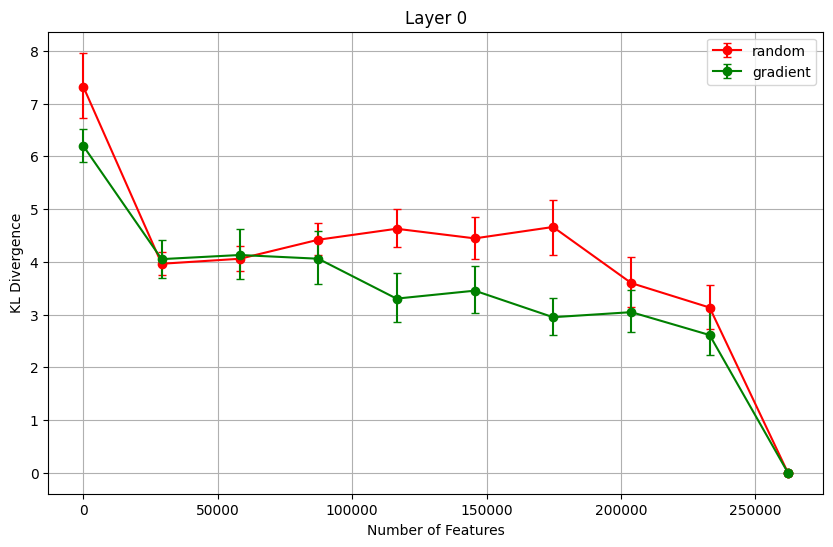

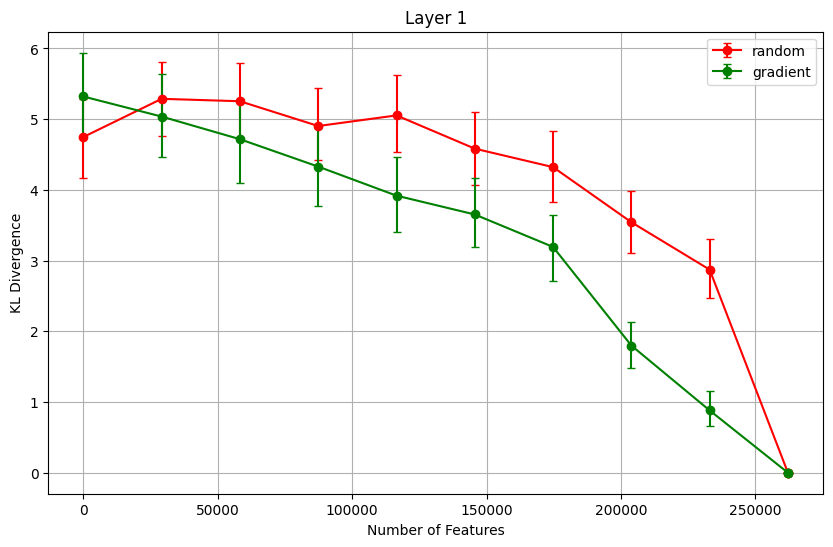

In [7]:
# PLOTTING

# If token_idx is not None, average over all token positions
token_idx = None 

# Lists to store results
mean_values = []
yerr_lower_values = []
yerr_upper_values = []

# Calculate statistics
for layer_idx in range(len(layers)):
    layer_means = []
    layer_yerr_lower = []
    layer_yerr_upper = []
    
    for method_idx in range(len(method_labels)):
        method_means = []
        method_yerr_lower = []
        method_yerr_upper = []
        
        for edge_idx in range(len(feature_counts_list[method_idx])):
            # If token_idx is not None, average over all token positions
            if token_idx is None:
                # Flatten the tensor to average over all dimensions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            else:
                # Flatten the tensor to average over specific token positions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx][:, token_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            
            # Compute mean and confidence interval
            mean_value = np.mean(flat_data)
            lower_ci, upper_ci = bootstrap_ci(flat_data)
            yerr_lower = mean_value - lower_ci
            yerr_upper = upper_ci - mean_value
            
            # Store values
            method_means.append(mean_value)
            method_yerr_lower.append(yerr_lower)
            method_yerr_upper.append(yerr_upper)
        
        layer_means.append(method_means)
        layer_yerr_lower.append(method_yerr_lower)
        layer_yerr_upper.append(method_yerr_upper)
    
    mean_values.append(layer_means)
    yerr_lower_values.append(layer_yerr_lower)
    yerr_upper_values.append(layer_yerr_upper)

# Plot results for each layer
plt.figure(figsize=(10, 6))
for layer_idx in range(len(layers)):
    plt.figure(figsize=(10, 6))
    for method_idx in range(len(method_labels)):
        plt.errorbar(
            feature_counts_list[method_idx], 
            mean_values[layer_idx][method_idx],
            yerr=[yerr_lower_values[layer_idx][method_idx], yerr_upper_values[layer_idx][method_idx]],
            fmt=colors[method_idx],
            capsize=3,
            label=method_labels[method_idx]
        )
    
    plt.xlabel('Number of Features')
    plt.ylabel('KL Divergence')
    plt.title(f'Layer {layers[layer_idx]}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Poster data

In [ ]:
# DATA LOADING
exp_output = 'kl_divergence_full_model' # Can choose from 'feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits'
data_dir = Path.cwd() / 'ablation_data' / 'SAE_poster_log_3P'
method_labels = ["standard", "top5", "topk", "top20"]
edge_sort = 'gradient'
layers = [0, 1, 2, 3]

kl_values_list = []
feature_counts_list = []

for method in method_labels:
    # Load experiments and extract logits
    layer_logits_values, feature_counts = load_experiments_and_extract_data(
        exp_output,
        data_dir, 
        method,
        edge_sort,
        layers
    )
    
    # Store results
    kl_values_list.append(layer_logits_values)
    feature_counts_list.append(feature_counts)
    

Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example experiment ID: magnitudes_top5_gradient_3_512_2025-05-06
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example experiment ID: magnitudes_top5_gradient_3_512_2025-05-06
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example exper

In [3]:
# DATA STRUCTURE

method_idx = 0
layer_idx = 0
edge_idx = 0
prompt_idx = 0
token_idx = 0

print(feature_counts_list[layer_idx][edge_idx]) # x-axis
print(kl_values_list[method_idx][layer_idx][edge_idx][prompt_idx][token_idx]) # y-axis

1
tensor(2.7653)


## Poster plotting

### SAE plots

In [ ]:
# DATA LOADING
exp_output = 'kl_divergence_full_model'
data_dir = Path.cwd() / 'ablation_data' / 'SAE_poster_log_3P'
method_labels = ["standard", "top5", "topk", "top20"]
edge_sort = 'gradient'
layers = [0, 1, 2, 3]

kl_values_list = []
feature_counts_list = []

for method in method_labels:
    # Load experiments and extract logits
    layer_logits_values, feature_counts = load_experiments_and_extract_data(
        exp_output,
        data_dir, 
        method,
        edge_sort,
        layers
    )
    
    # Store results
    kl_values_list.append(layer_logits_values)
    feature_counts_list.append(feature_counts)

Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example experiment ID: magnitudes_top5_gradient_3_512_2025-05-06
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example experiment ID: magnitudes_top5_gradient_3_512_2025-05-06
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 480 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/SAE_poster_log_3P

Example exper

In [5]:
# PREP DATA FOR PLOTTING

# Lists to store results
mean_values = []
yerr_lower_values = []
yerr_upper_values = []


token_idx = None 

# Calculate statistics
for layer_idx in range(len(layers)):
    layer_means = []
    layer_yerr_lower = []
    layer_yerr_upper = []
    
    for method_idx in range(len(method_labels)):
        method_means = []
        method_yerr_lower = []
        method_yerr_upper = []
        
        for edge_idx in range(len(feature_counts_list[method_idx])):
            # If token_idx is not None, average over all token positions
            if token_idx is None:
                # Flatten the tensor to average over all dimensions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            else:
                # Flatten the tensor to average over specific token positions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx][:, token_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            
            # Compute mean and confidence interval
            mean_value = np.mean(flat_data)
            lower_ci, upper_ci = bootstrap_ci(flat_data)
            yerr_lower = mean_value - lower_ci
            yerr_upper = upper_ci - mean_value
            
            # Store values
            method_means.append(mean_value)
            method_yerr_lower.append(yerr_lower)
            method_yerr_upper.append(yerr_upper)
        
        layer_means.append(method_means)
        layer_yerr_lower.append(method_yerr_lower)
        layer_yerr_upper.append(method_yerr_upper)
    
    mean_values.append(layer_means)
    yerr_lower_values.append(layer_yerr_lower)
    yerr_upper_values.append(layer_yerr_upper)

# Compute area under the curve for each layer and method
auc_values = []
auc_errors = []

for layer_idx in range(len(layers)):
    layer_auc = []
    layer_auc_error = []
    
    for method_idx in range(len(method_labels)):
        # Get x and y values for this layer and method
        x_values = feature_counts_list[method_idx]
        y_values = mean_values[layer_idx][method_idx]
        
        # Calculate AUC using trapezoidal rule
        auc = np.trapz(y_values, x_values)
        
        # Calculate AUC error by propagating the errors
        # Using lower and upper error bounds to estimate the uncertainty
        lower_values = [y - yerr for y, yerr in zip(y_values, yerr_lower_values[layer_idx][method_idx])]
        upper_values = [y + yerr for y, yerr in zip(y_values, yerr_upper_values[layer_idx][method_idx])]
        
        auc_lower = np.trapz(lower_values, x_values)
        auc_upper = np.trapz(upper_values, x_values)
        
        # Error as half the range between upper and lower bounds
        auc_error = (auc_upper - auc_lower) / 2
        
        layer_auc.append(auc)
        layer_auc_error.append(auc_error)
    
    auc_values.append(layer_auc)
    auc_errors.append(layer_auc_error)

/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_values, x_values)
/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_lower = np.trapz(lower_values, x_values)
/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_upper = np.trapz(upper_values, x_values)


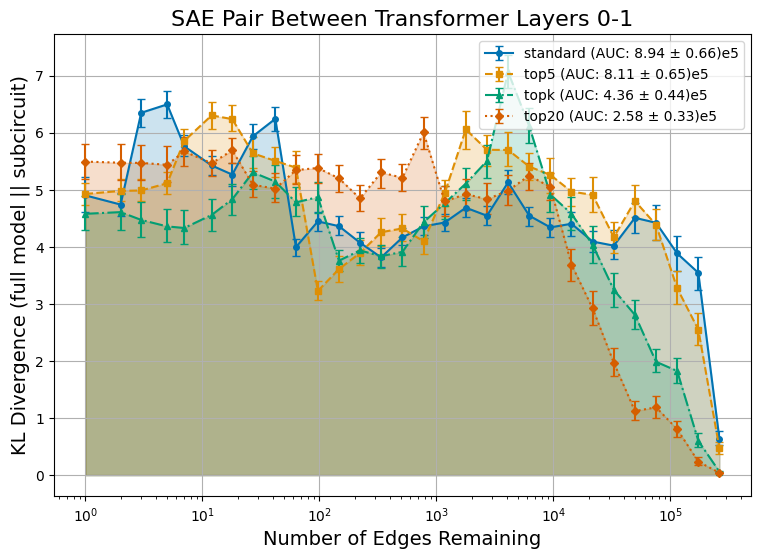

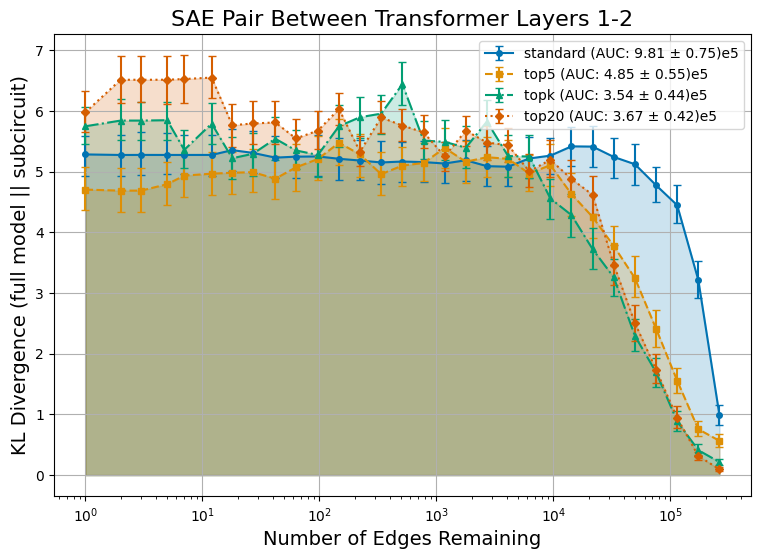

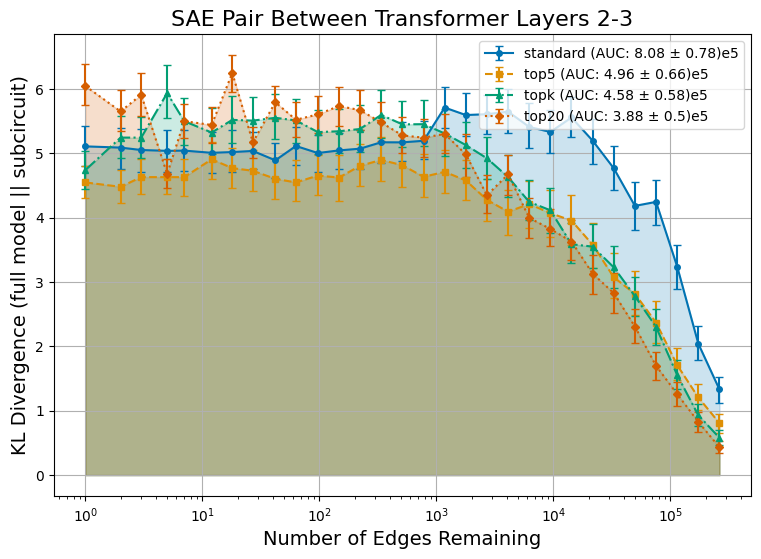

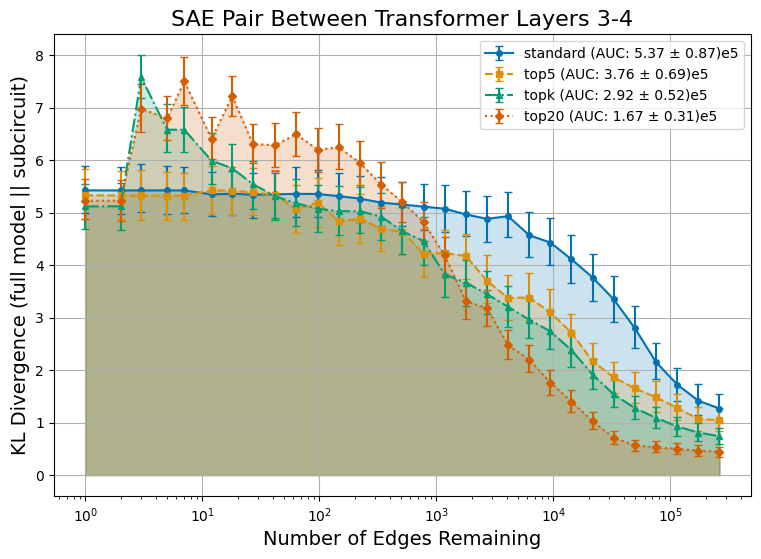

In [6]:
# PLOT RESULTS

# Get colorblind friendly palette
palette = sns.color_palette("colorblind", len(method_labels))

# Define line styles for each method
line_styles = ['-', '--', '-.', ':', '--', ':', '-.', ':', '--', ':', '--', ':', '--', ':']

# Define markers for each method
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'p', 'h', '+', 'x']

# Plot results for each layer
for layer_idx in range(len(layers)):
    plt.figure(figsize=(9, 6))
    for method_idx in range(len(method_labels)):
        # Add filled area under the curve
        plt.fill_between(
            feature_counts_list[method_idx],
            mean_values[layer_idx][method_idx],
            alpha=0.2,  # Transparency level
            color=palette[method_idx],  # Use colorblind friendly color
            label=None  # Don't add to legend
        )
        
        # Plot the line with error bars
        plt.errorbar(
            feature_counts_list[method_idx], 
            mean_values[layer_idx][method_idx],
            yerr=[yerr_lower_values[layer_idx][method_idx], yerr_upper_values[layer_idx][method_idx]],
            fmt=f'{markers[method_idx]}{line_styles[method_idx]}',  # Use marker and line style
            color=palette[method_idx],  # Use colorblind friendly color
            capsize=3,
            markersize=4,
            label=f"{method_labels[method_idx]} (AUC: {auc_values[layer_idx][method_idx]/1e5:.3g} ± {auc_errors[layer_idx][method_idx]/1e5:.2g})e5"
        )
    
    # Set a subset of x-ticks for better readability
    x_values = feature_counts_list[0]  # Use first method as reference
    num_ticks = 6  # Choose reasonable number of ticks
    indices = np.linspace(0, len(x_values)-1, num_ticks).astype(int)
    # tick_positions = [x_values[i] for i in indices]
    tick_positions = [x_values[0]] + [50000, 100000, 150000, 200000] + [x_values[-1]]  # Include first and last values
    
    plt.xticks(tick_positions)
    
    plt.xlabel('Number of Edges Remaining', fontsize=14)
    plt.xscale('log')  # Use log scale for x-axis
    plt.ylabel('KL Divergence (full model || subcircuit)', fontsize=14)
    plt.title(f'SAE Pair Between Transformer Layers {layers[layer_idx]}-{layers[layer_idx]+1}', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True)

    # filename = f"placeholder_jsae_pair_layer_{layers[layer_idx]}.png"
    # plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

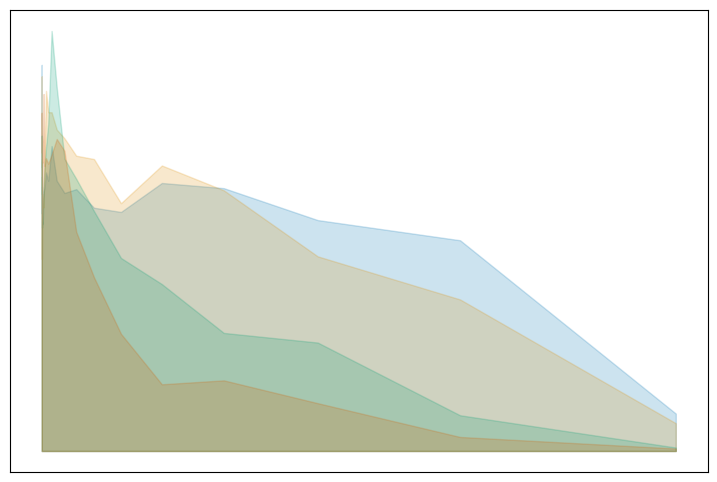

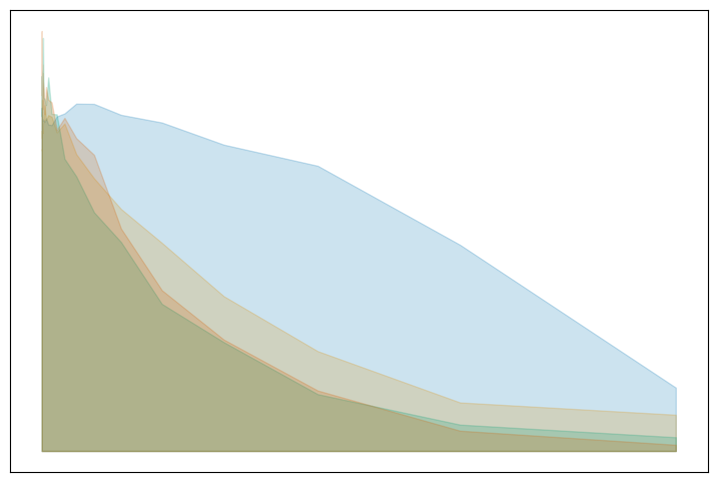

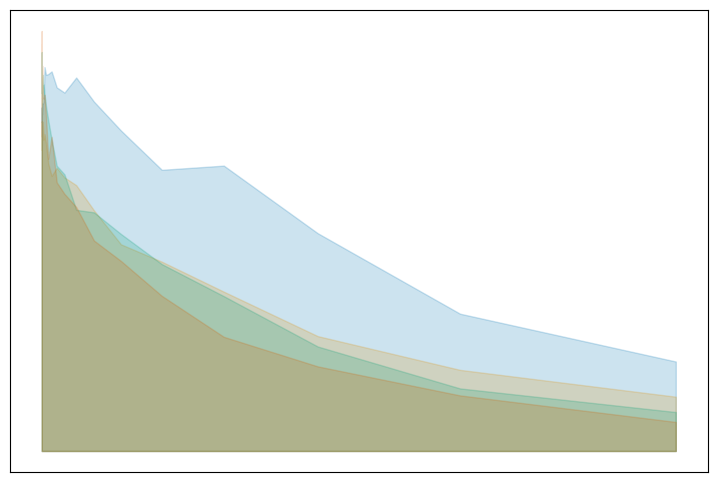

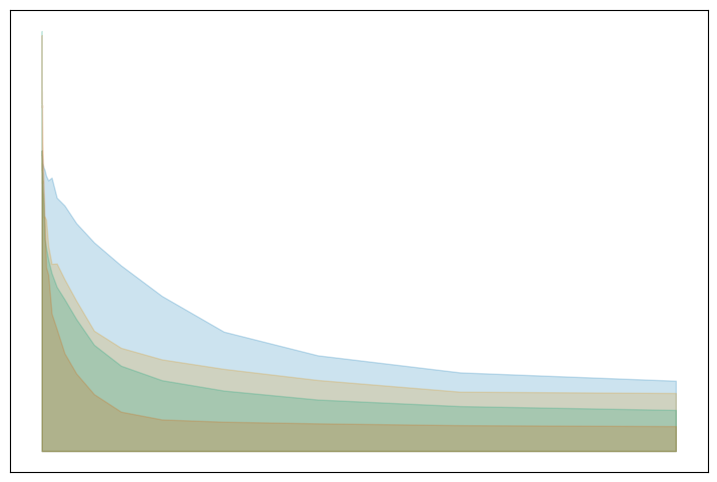

In [7]:
# PLOT RESULTS

# Get colorblind friendly palette
palette = sns.color_palette("colorblind", len(method_labels))

# Define line styles for each method
line_styles = ['-', '--', '-.', ':', '--', ':', '-.', ':', '--', ':', '--', ':', '--', ':']

# Define markers for each method
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'p', 'h', '+', 'x']

# Plot results for each layer
for layer_idx in range(len(layers)):
    plt.figure(figsize=(9, 6))
    for method_idx in range(len(method_labels)):
        # Get data for this method
        x_values = feature_counts_list[method_idx]
        y_values = mean_values[layer_idx][method_idx]
        
        # Add filled area under the curve
        plt.fill_between(
            x_values,
            y_values,
            alpha=0.2,  # Transparency level
            color=palette[method_idx],  # Use colorblind friendly color
            label=None  # Don't add to legend
        )

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.yticks([])

    plt.show()

### JSAE plots

In [ ]:
# DATA LOADING
exp_output = 'kl_divergence_full_model'
data_dir = Path.cwd() / 'ablation_data' / 'JSAE_poster_log_3P'
method_labels = ["0.0ep00", "1.0e-03", "1.2e-03", "1.5e-03", "1.8e-03", "2.2e-03", "2.7e-03", "3.3e-03", "3.9e-03", "4.7e-03"]
edge_sort = 'gradient'
layers = [0,1,2,3]

kl_values_list = []
feature_counts_list = []

for method in method_labels:
    # Load experiments and extract logits
    layer_logits_values, feature_counts = load_experiments_and_extract_data(
        exp_output,
        data_dir, 
        method,
        edge_sort,
        layers
    )
    
    # Store results
    kl_values_list.append(layer_logits_values)
    feature_counts_list.append(feature_counts)

Loaded 1290 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/JSAE_poster_log_3P

Example experiment ID: magnitudes_0.0ep00_gradient_3_75281_2025-05-08
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 1290 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/JSAE_poster_log_3P

Example experiment ID: magnitudes_0.0ep00_gradient_3_75281_2025-05-08
Available tensor keys: ['feature_magnitudes', 'kl_divergence', 'kl_divergence_full_model', 'logits']
Feature magnitudes shape: torch.Size([3, 128, 512])
Logits shape: torch.Size([3, 128, 128])
KL divergence shape: torch.Size([3, 128])
Loaded 1290 experiments from /Users/xavierponcini/Documents/projects/spar/gpt-circuits/xavier/experiments/data/JSAE_poster_log_3

In [9]:
# PREP DATA FOR PLOTTING

# Lists to store results
mean_values = []
yerr_lower_values = []
yerr_upper_values = []


token_idx = None 

# Calculate statistics
for layer_idx in range(len(layers)):
    layer_means = []
    layer_yerr_lower = []
    layer_yerr_upper = []
    
    for method_idx in range(len(method_labels)):
        method_means = []
        method_yerr_lower = []
        method_yerr_upper = []
        
        for edge_idx in range(len(feature_counts_list[method_idx])):
            # If token_idx is not None, average over all token positions
            if token_idx is None:
                # Flatten the tensor to average over all dimensions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            else:
                # Flatten the tensor to average over specific token positions
                tensor = kl_values_list[method_idx][layer_idx][edge_idx][:, token_idx]
                flat_data = tensor.flatten()
                if isinstance(flat_data, torch.Tensor):
                    flat_data = flat_data.numpy()
            
            # Compute mean and confidence interval
            mean_value = np.mean(flat_data)
            lower_ci, upper_ci = bootstrap_ci(flat_data)
            yerr_lower = mean_value - lower_ci
            yerr_upper = upper_ci - mean_value
            
            # Store values
            method_means.append(mean_value)
            method_yerr_lower.append(yerr_lower)
            method_yerr_upper.append(yerr_upper)
        
        layer_means.append(method_means)
        layer_yerr_lower.append(method_yerr_lower)
        layer_yerr_upper.append(method_yerr_upper)
    
    mean_values.append(layer_means)
    yerr_lower_values.append(layer_yerr_lower)
    yerr_upper_values.append(layer_yerr_upper)

# Compute area under the curve for each layer and method
auc_values = []
auc_errors = []

for layer_idx in range(len(layers)):
    layer_auc = []
    layer_auc_error = []
    
    for method_idx in range(len(method_labels)):
        # Get x and y values for this layer and method
        x_values = feature_counts_list[method_idx]
        y_values = mean_values[layer_idx][method_idx]
        
        # Calculate AUC using trapezoidal rule
        auc = np.trapz(y_values, x_values)
        
        # Calculate AUC error by propagating the errors
        # Using lower and upper error bounds to estimate the uncertainty
        lower_values = [y - yerr for y, yerr in zip(y_values, yerr_lower_values[layer_idx][method_idx])]
        upper_values = [y + yerr for y, yerr in zip(y_values, yerr_upper_values[layer_idx][method_idx])]
        
        auc_lower = np.trapz(lower_values, x_values)
        auc_upper = np.trapz(upper_values, x_values)
        
        # Error as half the range between upper and lower bounds
        auc_error = (auc_upper - auc_lower) / 2
        
        layer_auc.append(auc)
        layer_auc_error.append(auc_error)
    
    auc_values.append(layer_auc)
    auc_errors.append(layer_auc_error)

/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_values, x_values)
/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_lower = np.trapz(lower_values, x_values)
/var/folders/10/bwnp23qs67qdg2r6bkx298d00000gn/T/ipykernel_20253/255390417.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_upper = np.trapz(upper_values, x_values)


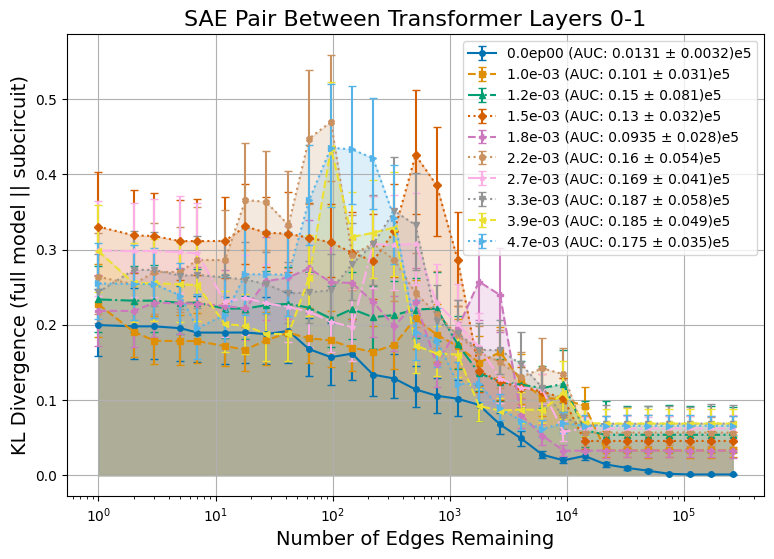

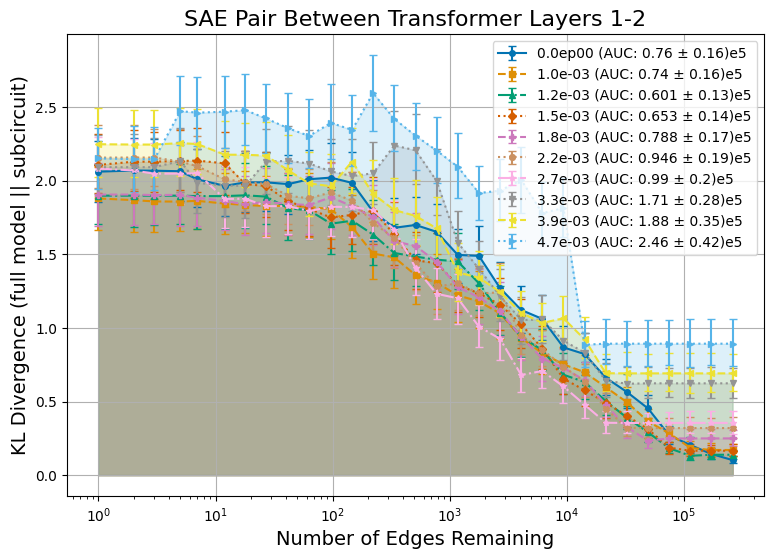

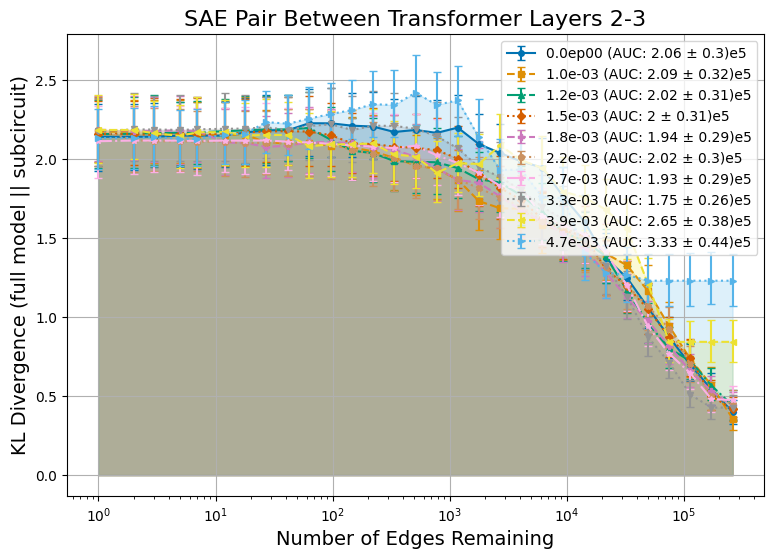

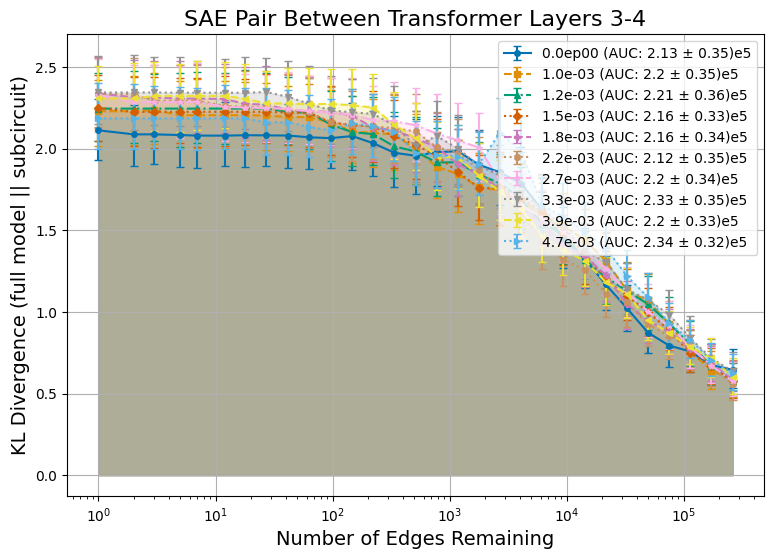

In [10]:
# PLOT RESULTS

# Get colorblind friendly palette
palette = sns.color_palette("colorblind", len(method_labels))

# Define line styles for each method
line_styles = ['-', '--', '-.', ':', '--', ':', '-.', ':', '--', ':', '--', ':', '--', ':']

# Define markers for each method
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'p', 'h', '+', 'x']

# Plot results for each layer
for layer_idx in range(len(layers)):
    plt.figure(figsize=(9, 6))
    for method_idx in range(len(method_labels)):
        # Add filled area under the curve
        plt.fill_between(
            feature_counts_list[method_idx],
            mean_values[layer_idx][method_idx],
            alpha=0.2,  # Transparency level
            color=palette[method_idx],  # Use colorblind friendly color
            label=None  # Don't add to legend
        )
        
        # Plot the line with error bars
        plt.errorbar(
            feature_counts_list[method_idx], 
            mean_values[layer_idx][method_idx],
            yerr=[yerr_lower_values[layer_idx][method_idx], yerr_upper_values[layer_idx][method_idx]],
            fmt=f'{markers[method_idx]}{line_styles[method_idx]}',  # Use marker and line style
            color=palette[method_idx],  # Use colorblind friendly color
            capsize=3,
            markersize=4,
            label=f"{method_labels[method_idx]} (AUC: {auc_values[layer_idx][method_idx]/1e5:.3g} ± {auc_errors[layer_idx][method_idx]/1e5:.2g})e5"
        )
    
    # Set a subset of x-ticks for better readability
    x_values = feature_counts_list[0]  # Use first method as reference
    num_ticks = 6  # Choose reasonable number of ticks
    indices = np.linspace(0, len(x_values)-1, num_ticks).astype(int)
    # tick_positions = [x_values[i] for i in indices]
    tick_positions = [x_values[0]] + [50000, 100000, 150000, 200000] + [x_values[-1]]  # Include first and last values
    
    plt.xticks(tick_positions)
    
    plt.xlabel('Number of Edges Remaining', fontsize=14)
    plt.xscale('log')  # Use log scale for x-axis
    plt.ylabel('KL Divergence (full model || subcircuit)', fontsize=14)
    plt.title(f'SAE Pair Between Transformer Layers {layers[layer_idx]}-{layers[layer_idx]+1}', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True)

    # filename = f"placeholder_jsae_pair_layer_{layers[layer_idx]}.png"
    # plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

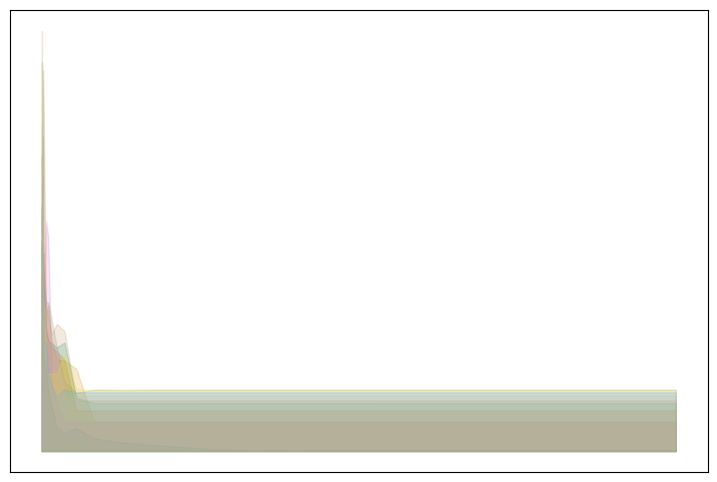

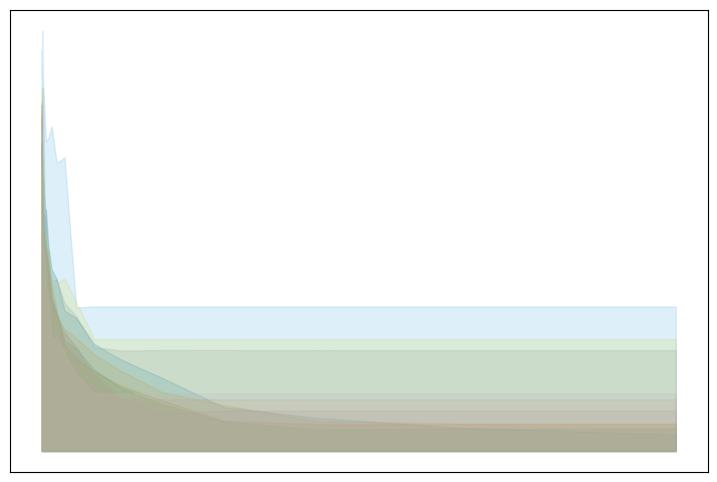

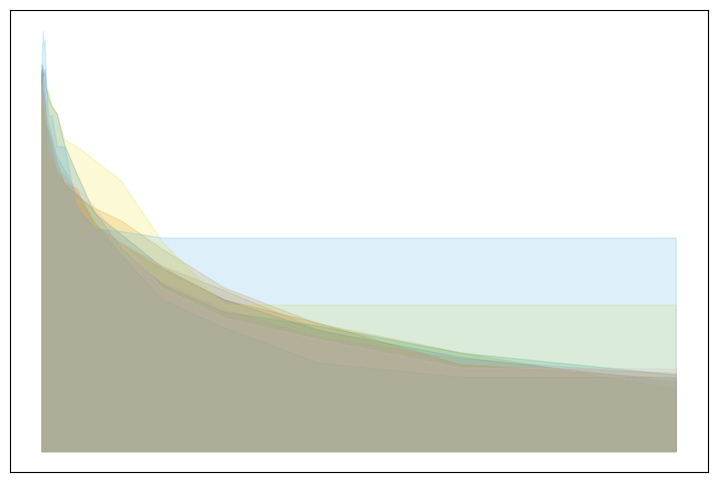

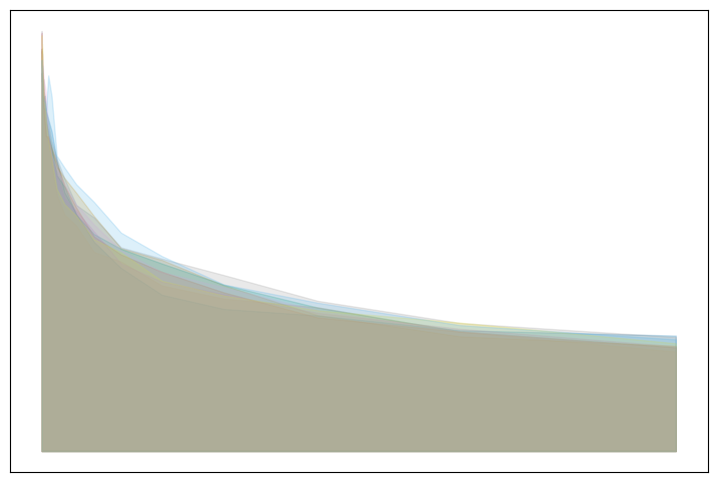

In [11]:
# PLOT RESULTS

# Get colorblind friendly palette
palette = sns.color_palette("colorblind", len(method_labels))

# Define line styles for each method
line_styles = ['-', '--', '-.', ':', '--', ':', '-.', ':', '--', ':', '--', ':', '--', ':']

# Define markers for each method
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'p', 'h', '+', 'x']

# Plot results for each layer
for layer_idx in range(len(layers)):
    plt.figure(figsize=(9, 6))
    for method_idx in range(len(method_labels)):
        # Get data for this method
        x_values = feature_counts_list[method_idx]
        y_values = mean_values[layer_idx][method_idx]
        
        # Add filled area under the curve
        plt.fill_between(
            x_values,
            y_values,
            alpha=0.2,  # Transparency level
            color=palette[method_idx],  # Use colorblind friendly color
            label=None  # Don't add to legend
        )

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.yticks([])

    plt.show()